CARDIO VASCULAR DISEASE Cardiovascular disease (CVD) encompasses a range of heart and blood vessel disorders, including coronary artery disease, heart attacks, and strokes. It is a leading cause of death globally, often linked to lifestyle factors such as poor diet, lack of exercise, and smoking. Prevention focuses on healthy living and early detection through regular health screenings. Effective management includes medications, lifestyle changes, and sometimes surgical interventions ##Objective To develop and evaluate machine learning models for predicting the risk of cardiovascular disease using various algorithms, including Support Vector Machines (SVM), K-Nearest Neighbor (KNN), Decision Trees (DT), Logistic Regression (LR), and Random Forest (RF). By comparing the performance of these models, the project aims to identify the most accurate and reliable method for early detection and risk assessment of cardiovascular disease, thereby contributing to improved preventive measures and patient outcomes.
Dataset The dataset used in this project includes several key features related to cardiovascular disease: age, cardiovascular disease status (cardio), weight, cholesterol levels, smoking habits, gender, and alcohol consumption. Each entry is uniquely identified by an ID. This dataset provides a comprehensive overview of factors influencing cardiovascular health, offering a robust foundation for developing predictive models using machine learning techniques. By analyzing these features, we aim to uncover patterns and correlations that can assist in early detection and effective risk management of cardiovascular disease.





## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp


<ipython-input-4-35bc967233c8>:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


In [ ]:
# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.12.0


In [ ]:
pip install tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.12.0 which is incompatible.


In [ ]:
# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
data = pd.read_csv("/content/cardio_train.csv.zip", sep=";")

In [ ]:
# FE - thanks to: https://www.kaggle.com/benanakca/comparison-of-classification-disease-prediction
data.drop("id",axis=1,inplace=True)
data.drop_duplicates(inplace=True)
data["bmi"] = data["weight"] / (data["height"]/100)**2
out_filter = ((data["ap_hi"]>250) | (data["ap_lo"]>200))
data = data[~out_filter]
len(data)

68983

In [ ]:
out_filter2 = ((data["ap_hi"] < 0) | (data["ap_lo"] < 0))
data = data[~out_filter2]

In [ ]:
data.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68975 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68975 non-null  int64  
 1   gender       68975 non-null  int64  
 2   height       68975 non-null  int64  
 3   weight       68975 non-null  float64
 4   ap_hi        68975 non-null  int64  
 5   ap_lo        68975 non-null  int64  
 6   cholesterol  68975 non-null  int64  
 7   gluc         68975 non-null  int64  
 8   smoke        68975 non-null  int64  
 9   alco         68975 non-null  int64  
 10  active       68975 non-null  int64  
 11  cardio       68975 non-null  int64  
 12  bmi          68975 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 7.4 MB


## 3. EDA <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

This code is based on my kernel "[FE & EDA with Pandas Profiling](https://www.kaggle.com/vbmokin/fe-eda-with-pandas-profiling)"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = data.apply(pd.to_numeric)
df['age'] = df['age'] // 365

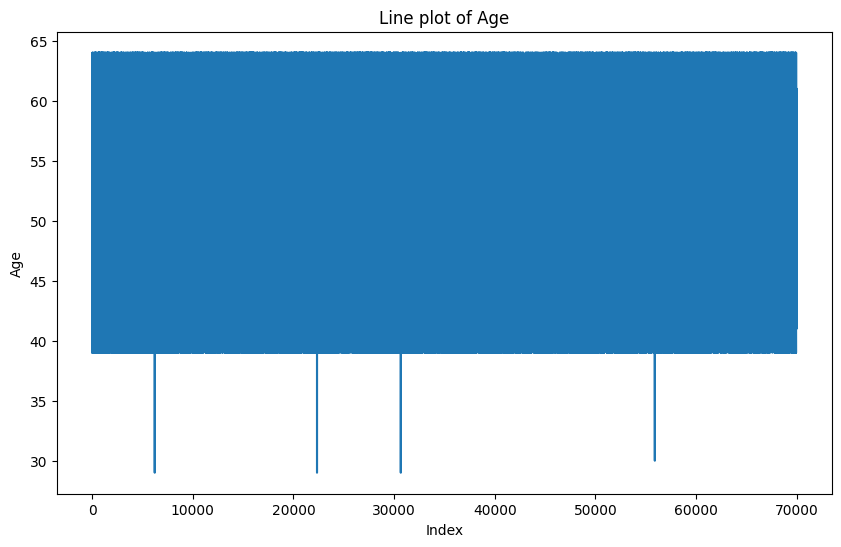

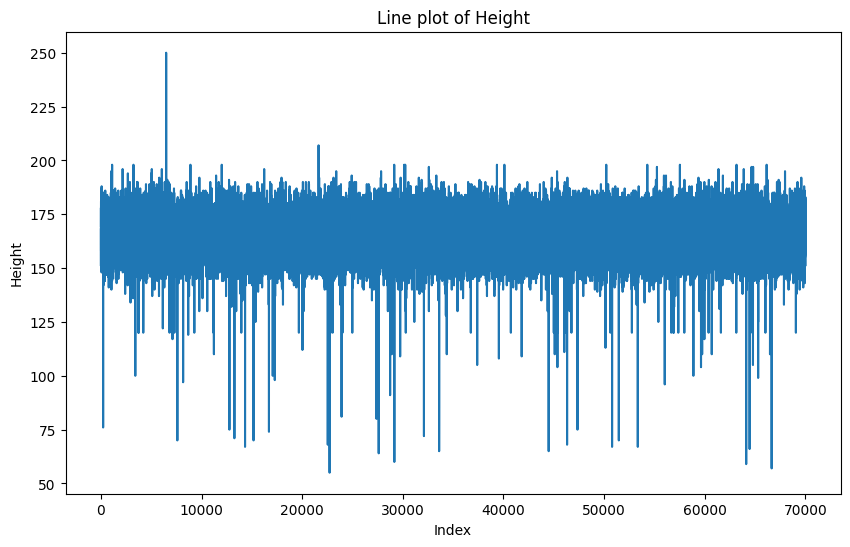

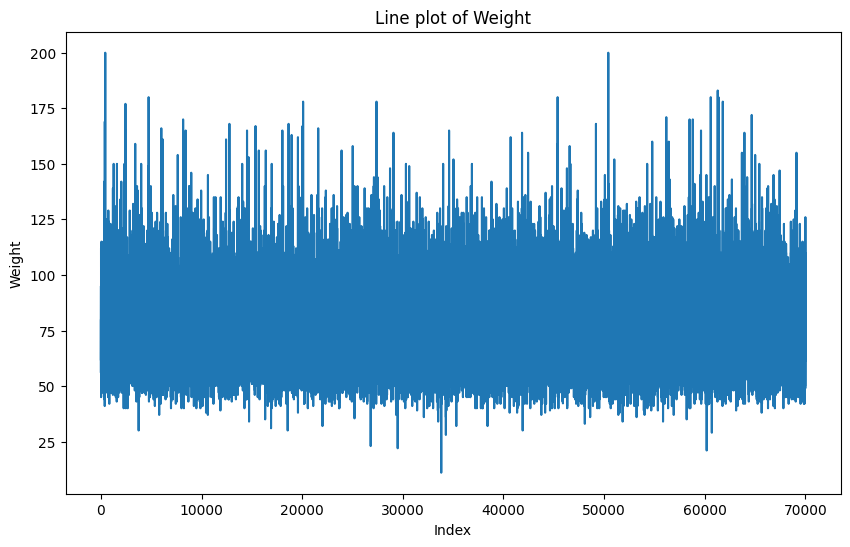

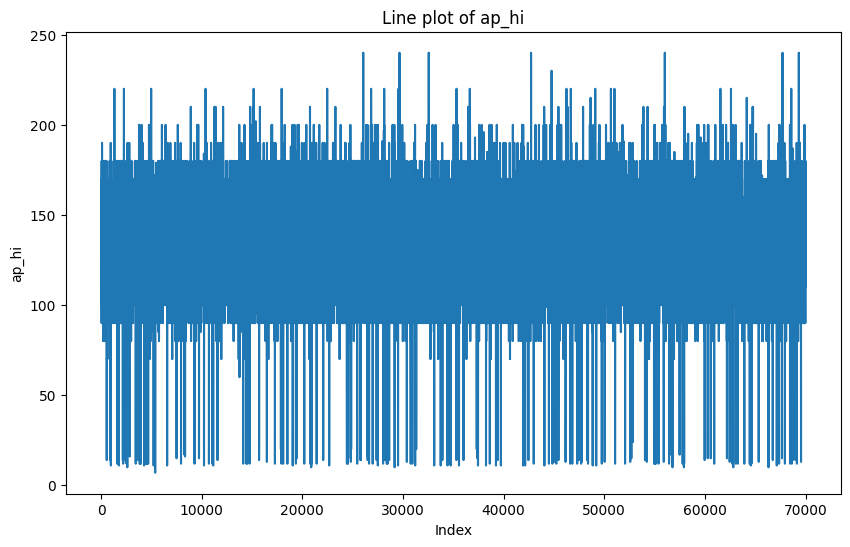

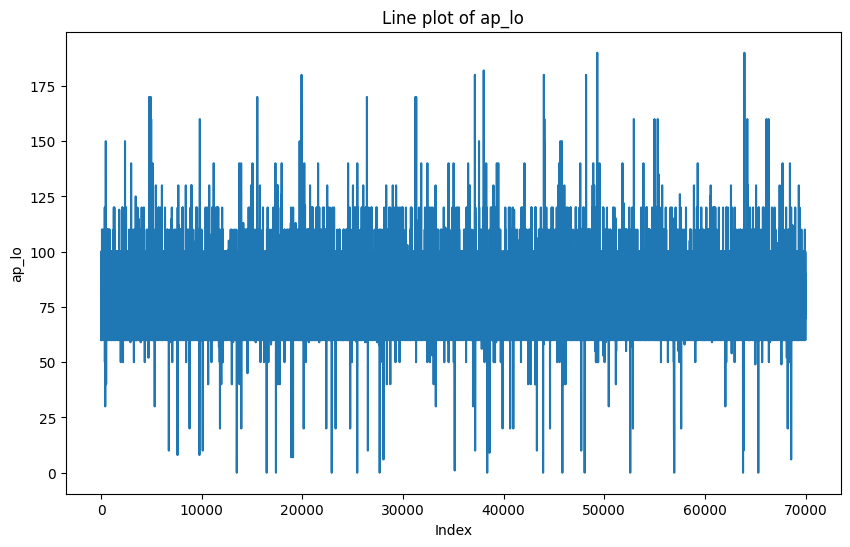

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df['age'])
plt.title('Line plot of Age')
plt.ylabel('Age')
plt.xlabel('Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df['height'])
plt.title('Line plot of Height')
plt.ylabel('Height')
plt.xlabel('Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df['weight'])
plt.title('Line plot of Weight')
plt.ylabel('Weight')
plt.xlabel('Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df['ap_hi'])
plt.title('Line plot of ap_hi')
plt.ylabel('ap_hi')
plt.xlabel('Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df['ap_lo'])
plt.title('Line plot of ap_lo')
plt.ylabel('ap_lo')
plt.xlabel('Index')
plt.show()

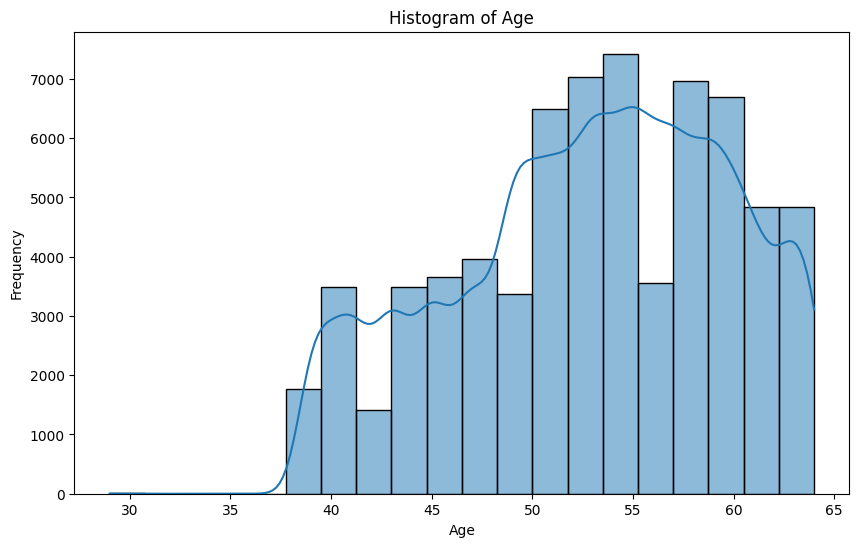

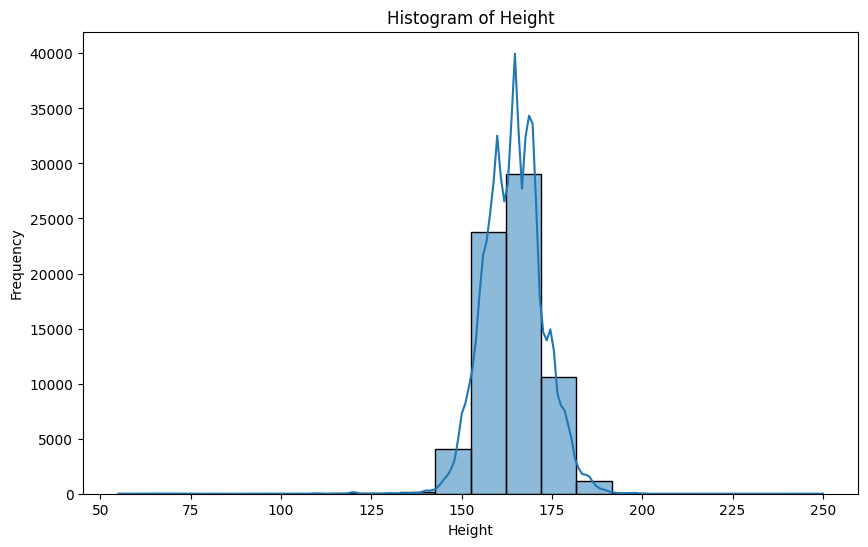

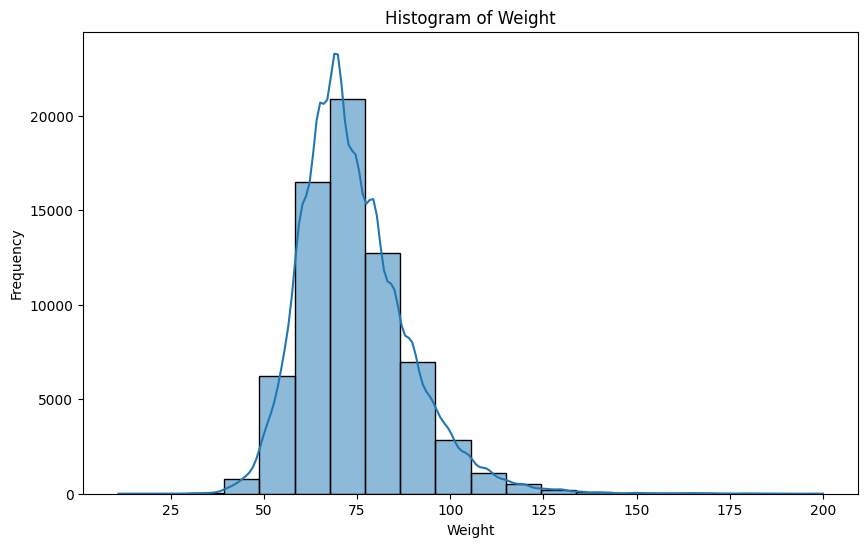

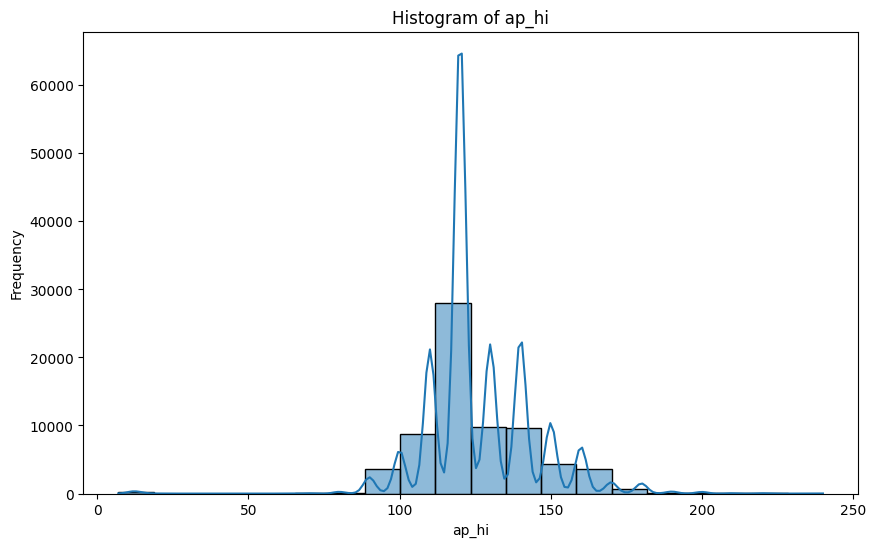

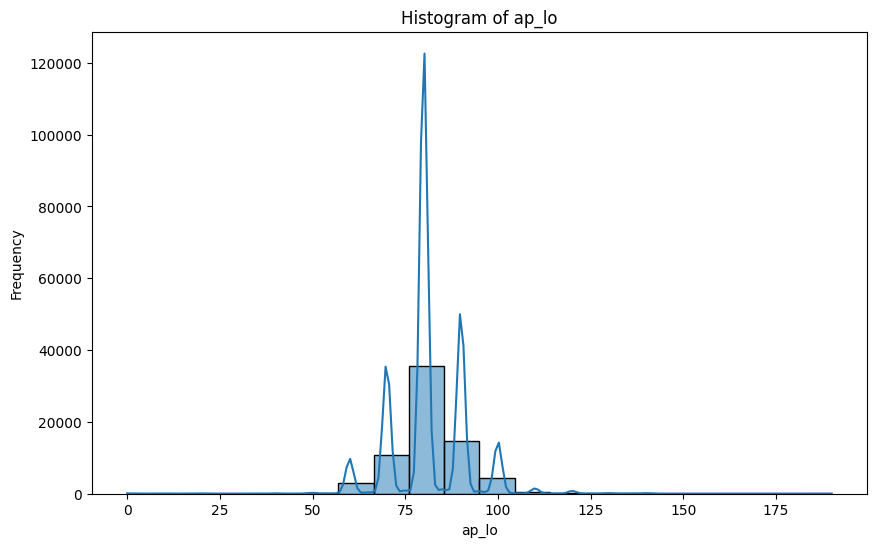

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['height'], bins=20, kde=True)
plt.title('Histogram of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['weight'], bins=20, kde=True)
plt.title('Histogram of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['ap_hi'], bins=20, kde=True)
plt.title('Histogram of ap_hi')
plt.xlabel('ap_hi')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['ap_lo'], bins=20, kde=True)
plt.title('Histogram of ap_lo')
plt.xlabel('ap_lo')
plt.ylabel('Frequency')
plt.show()

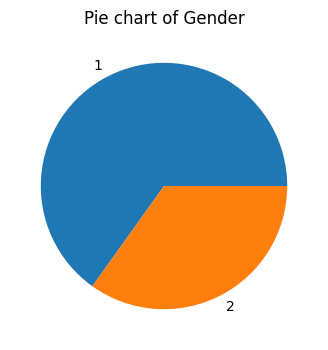

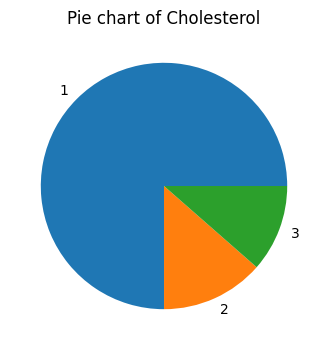

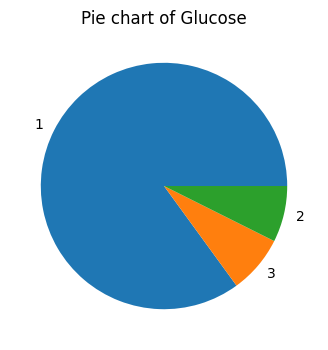

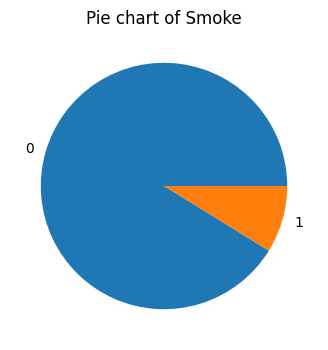

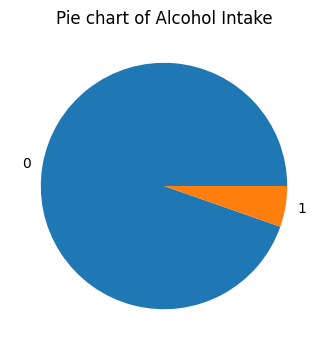

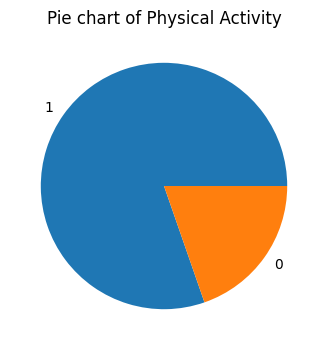

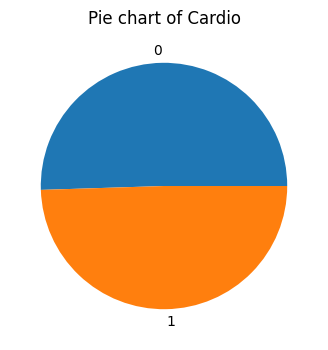

In [ ]:
plt.figure(figsize=(5,4))
df['gender'].value_counts().plot.pie()
plt.title('Pie chart of Gender')
plt.ylabel('')
plt.show()

plt.figure(figsize=(5,4))
df['cholesterol'].value_counts().plot.pie()
plt.title('Pie chart of Cholesterol')
plt.ylabel('')
plt.show()

plt.figure(figsize=(5,4))
df['gluc'].value_counts().plot.pie()
plt.title('Pie chart of Glucose')
plt.ylabel('')
plt.show()

plt.figure(figsize=(5,4))
df['smoke'].value_counts().plot.pie()
plt.title('Pie chart of Smoke')
plt.ylabel('')
plt.show()

plt.figure(figsize=(5,4))
df['alco'].value_counts().plot.pie()
plt.title('Pie chart of Alcohol Intake')
plt.ylabel('')
plt.show()

plt.figure(figsize=(5,4))
df['active'].value_counts().plot.pie()
plt.title('Pie chart of Physical Activity')
plt.ylabel('')
plt.show()

plt.figure(figsize=(5,4))
df['cardio'].value_counts().plot.pie()
plt.title('Pie chart of Cardio')
plt.ylabel('')
plt.show()

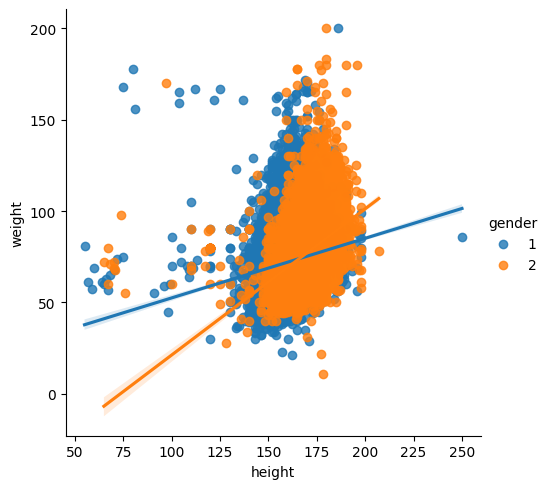

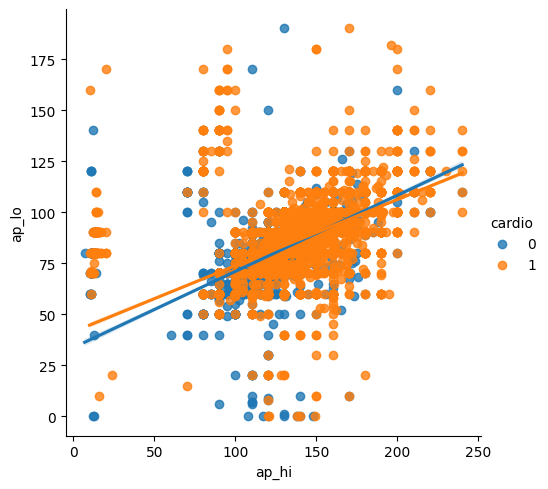

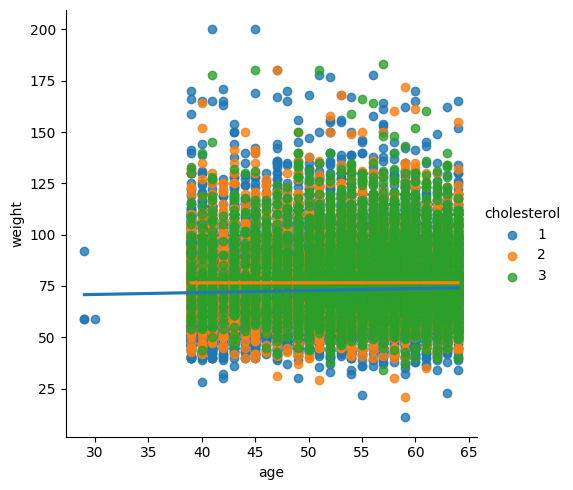

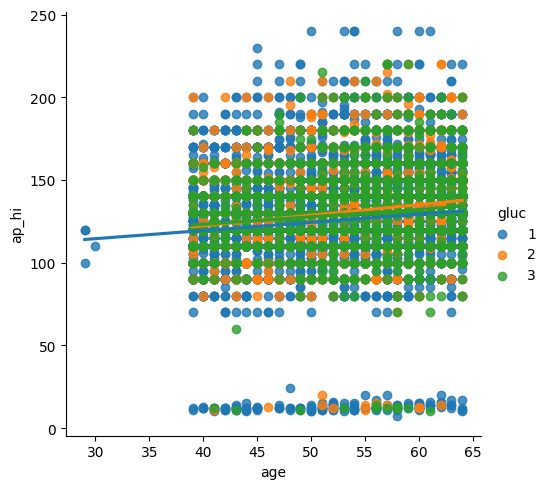

In [ ]:
sns.lmplot(x='height', y='weight', data=df, hue='gender')
sns.lmplot(x='ap_hi', y='ap_lo', data=df, hue='cardio')
sns.lmplot(x='age', y='weight', data=df, hue='cholesterol')
sns.lmplot(x='age', y='ap_hi', data=df, hue='gluc')

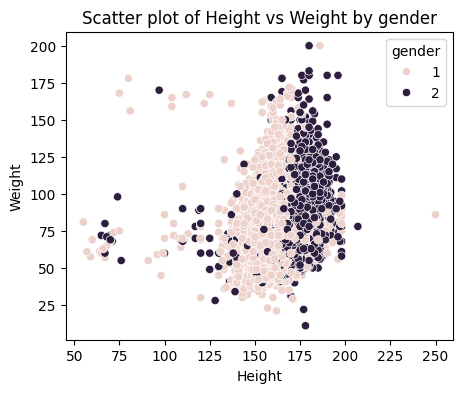

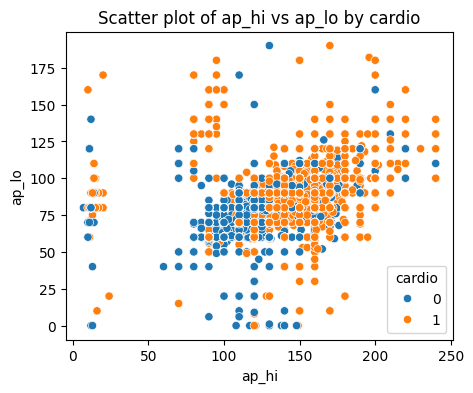

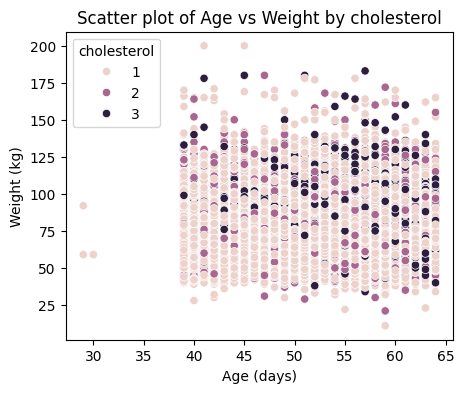

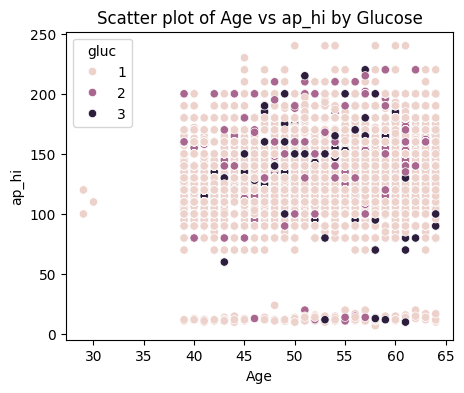

In [ ]:
plt.figure(figsize=(5,4))
sns.scatterplot(x='height', y='weight', hue='gender', data=df)
plt.title('Scatter plot of Height vs Weight by gender')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

plt.figure(figsize=(5,4))
sns.scatterplot(x='ap_hi', y='ap_lo', hue='cardio', data=df)
plt.title('Scatter plot of ap_hi vs ap_lo by cardio')
plt.xlabel('ap_hi')
plt.ylabel('ap_lo')
plt.show()

plt.figure(figsize=(5,4))
sns.scatterplot(x='age', y='weight', hue='cholesterol', data=df)
plt.title('Scatter plot of Age vs Weight by cholesterol')
plt.xlabel('Age (days)')
plt.ylabel('Weight (kg)')
plt.show()

plt.figure(figsize=(5,4))
sns.scatterplot(x='age', y='ap_hi', hue='gluc', data=df)
plt.title('Scatter plot of Age vs ap_hi by Glucose')
plt.xlabel('Age')
plt.ylabel('ap_hi')
plt.show()

In [ ]:
# Calculate correlation matrix
correlation_matrix = df.corr()
correlation_matrix

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
age,1.000000,-0.023209,-0.080764,0.055036,0.197435,0.150824,0.155035,0.098830,-0.047797,-0.029120,-0.010470,0.239594,0.086206
gender,-0.023209,1.000000,0.498059,0.155884,0.058164,0.064688,-0.036810,-0.021042,0.338664,0.170995,0.005569,0.007457,-0.096020
height,-0.080764,0.498059,1.000000,0.291543,0.017634,0.035880,-0.050481,-0.018520,0.187973,0.094473,-0.007296,-0.010447,-0.292333
weight,0.055036,0.155884,0.291543,1.000000,0.255102,0.245313,0.140590,0.106840,0.066725,0.067891,-0.017975,0.179922,0.759486
ap_hi,0.197435,0.058164,0.017634,0.255102,1.000000,0.646263,0.186258,0.087928,0.028047,0.031521,0.000689,0.401392,0.216872
ap_lo,0.150824,0.064688,0.035880,0.245313,0.646263,1.000000,0.155411,0.076024,0.024575,0.042927,-0.000938,0.328875,0.200074
cholesterol,0.155035,-0.036810,-0.050481,0.140590,0.186258,0.155411,1.000000,0.450808,0.009805,0.035563,0.008974,0.221377,0.144972
gluc,0.098830,-0.021042,-0.018520,0.106840,0.087928,0.076024,0.450808,1.000000,-0.005717,0.011196,-0.007733,0.089734,0.100984
smoke,-0.047797,0.338664,0.187973,0.066725,0.028047,0.024575,0.009805,-0.005717,1.000000,0.340269,0.025727,-0.016372,-0.028210
alco,-0.029120,0.170995,0.094473,0.067891,0.031521,0.042927,0.035563,0.011196,0.340269,1.000000,0.025336,-0.008151,0.014808


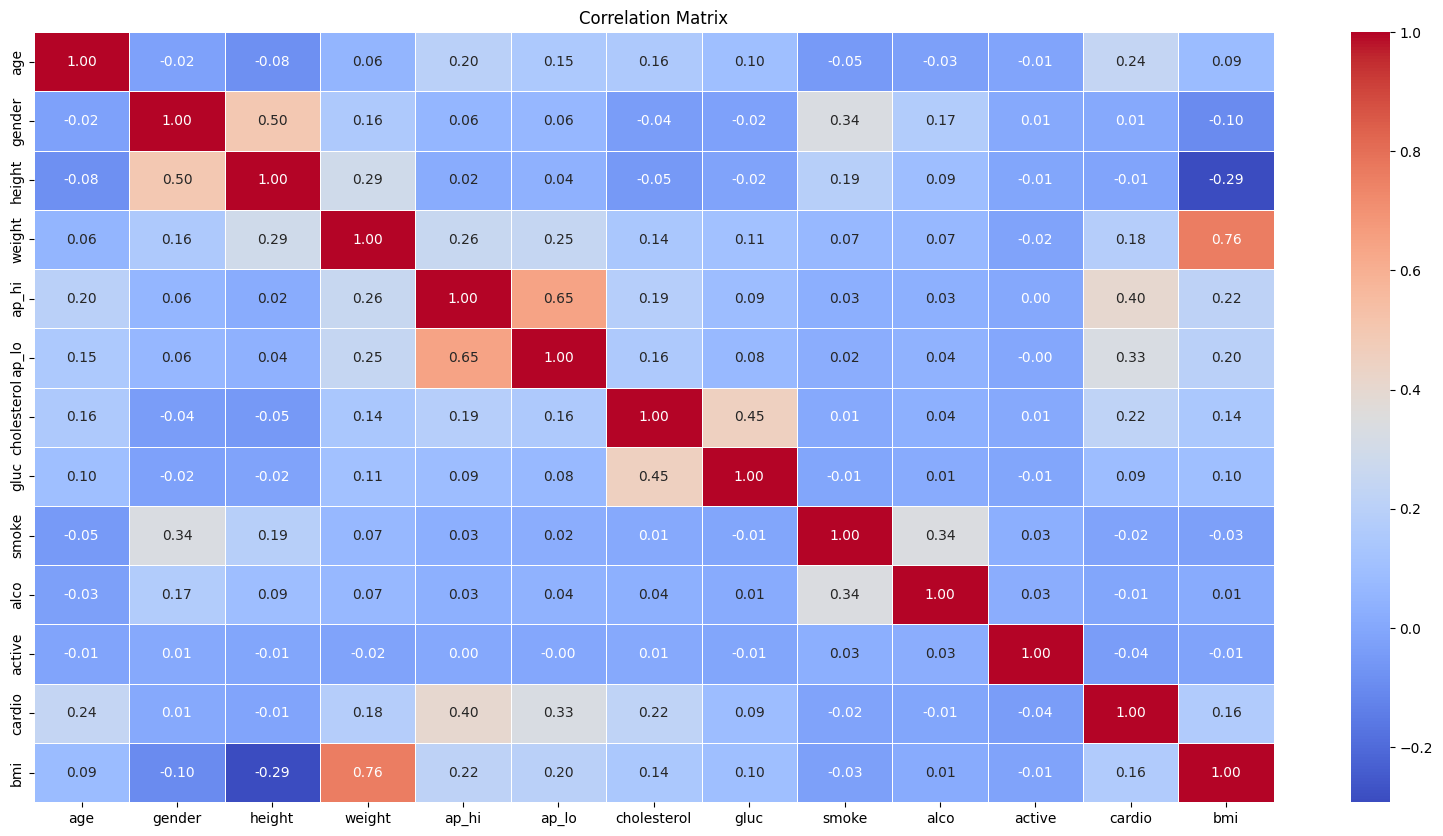

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True,  cmap='coolwarm',fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## 4. Preparing to modeling <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
target_name = 'cardio'
data_target = data[target_name]
data = data.drop([target_name], axis=1)

I split data on 30% in the test dataset, the remaining 70% - in the training dataset

In [ ]:
train, test, target, target_test = train_test_split(data, data_target, test_size=0.2, random_state=0)

In [ ]:
train.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
31684,21263,2,160,76.0,130,80,1,1,0,1,1,29.687500
5634,14684,2,184,70.0,120,80,1,1,0,0,1,20.675803
58675,23436,1,158,76.0,120,80,1,1,0,0,1,30.443839


In [ ]:
test.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
51756,20272,1,161,75.0,120,80,1,1,0,0,1,28.934069
9378,21872,1,175,70.0,120,70,1,1,0,0,1,22.857143
5060,18140,1,165,65.0,120,80,2,2,0,0,1,23.875115


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55180 entries, 31684 to 69281
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          55180 non-null  int64  
 1   gender       55180 non-null  int64  
 2   height       55180 non-null  int64  
 3   weight       55180 non-null  float64
 4   ap_hi        55180 non-null  int64  
 5   ap_lo        55180 non-null  int64  
 6   cholesterol  55180 non-null  int64  
 7   gluc         55180 non-null  int64  
 8   smoke        55180 non-null  int64  
 9   alco         55180 non-null  int64  
 10  active       55180 non-null  int64  
 11  bmi          55180 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 5.5 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13795 entries, 51756 to 61199
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          13795 non-null  int64  
 1   gender       13795 non-null  int64  
 2   height       13795 non-null  int64  
 3   weight       13795 non-null  float64
 4   ap_hi        13795 non-null  int64  
 5   ap_lo        13795 non-null  int64  
 6   cholesterol  13795 non-null  int64  
 7   gluc         13795 non-null  int64  
 8   smoke        13795 non-null  int64  
 9   alco         13795 non-null  int64  
 10  active       13795 non-null  int64  
 11  bmi          13795 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 1.4 MB


In [ ]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.2, random_state=0)

## 5. Tuning models and test for all features <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

### 5.1 Logistic Regression <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

71.64

In [ ]:
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

71.89

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

- *gluc* is highest coefficient
- *height*, *smoke* are largest numbers by absolute value.

In [ ]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,ap_hi,0.071372
4,ap_lo,0.051381
6,gluc,0.028267
5,cholesterol,0.011089
1,height,0.008326
7,smoke,0.004990
8,alco,0.000611
0,gender,0.000149
9,active,-0.000914
10,bmi,-0.008568


### 5.2 Support Vector Machines <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(train, target)
acc_svc = round(svc.score(train, target) * 100, 2)
acc_svc

In [ ]:
acc_test_svc = round(svc.score(test, target_test) * 100, 2)
acc_test_svc

### 5.3 Linear SVC <a class="anchor" id="5.3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Linear SVC

linear_svc = LinearSVC(dual=False)  # dual=False when n_samples > n_features.
linear_svc.fit(train, target)
acc_linear_svc = round(linear_svc.score(train, target) * 100, 2)
acc_linear_svc

In [ ]:
acc_test_linear_svc = round(linear_svc.score(test, target_test) * 100, 2)
acc_test_linear_svc

### 5.4 k-Nearest Neighbors algorithm <a class="anchor" id="5.4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# k-Nearest Neighbors algorithm

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3]}, cv=10).fit(train, target)
acc_knn = round(knn.score(train, target) * 100, 2)
print(acc_knn, knn.best_params_)

In [ ]:
acc_test_knn = round(knn.score(test, target_test) * 100, 2)
acc_test_knn

### 5.8 Decision Tree Classifier <a class="anchor" id="5.8"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

In [ ]:
acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
acc_test_decision_tree

### 5.9 Random Forests <a class="anchor" id="5.9"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

In [ ]:
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
acc_test_random_forest

### 5.16 Neural Network 1 <a class="anchor" id="5.16"></a>

[Back to Table of Contents](#0.1)

**Neural networks** are more complex and more powerful algorithm than standars machine learning, it belongs to deep learning models. To build a neural network use Keras. Keras is a high level API for tensorflow, which is a tensor-manipulation framework made by google. Keras allows you to build neural networks by assembling blocks (which are the layers of neural network).

In [ ]:
def build_ann(optimizer='adam'):

    # Initializing the ANN
    ann = Sequential()

    # Adding the input layer and the first hidden layer of the ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(len(train.columns),)))

    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))

    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))

    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return ann

In [ ]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
# Training the ANN
history = ann.fit(Xtrain, Ztrain, batch_size=16, epochs=100, validation_data=(Xval, Zval))

In [ ]:
# Predicting the Train set results
ann_prediction = ann.predict(train)
ann_prediction = (ann_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_ann1 = round(metrics.accuracy_score(target, ann_prediction) * 100, 2)
acc_ann1

In [ ]:
# Predicting the Test set results
ann_prediction_test = ann.predict(test)
ann_prediction_test = (ann_prediction_test > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_test_ann1 = round(metrics.accuracy_score(target_test, ann_prediction_test) * 100, 2)
acc_test_ann1

## 6. Models evaluation <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

We can now rank our evaluation of all the models to choose the best one for our problem.

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 'k-Nearest Neighbors',
              'Decision Tree Classifier', 'Random Forest',
              'Neural Network 1',],

    'Score_train': [acc_log, acc_svc, acc_linear_svc, acc_knn,
              acc_decision_tree, acc_random_forest,
              acc_ann1,],
    'Score_test': [acc_test_log, acc_test_svc, acc_test_linear_svc, acc_test_knn,
              acc_test_decision_tree, acc_test_random_forest,
              acc_test_ann1,]
                    })

In [ ]:
models.sort_values(by=['Score_train', 'Score_test'], ascending=False)

In [ ]:
models.sort_values(by=['Score_test', 'Score_train'], ascending=False)

In [ ]:
models['Score_diff'] = abs(models['Score_train'] - models['Score_test'])
models.sort_values(by=['Score_diff'], ascending=True)

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['Score_train'], label = 'Score_train')
plt.plot(xx, models['Score_test'], label = 'Score_test')
plt.legend()
plt.title('Score of 20 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Score, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()